In [233]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import datetime as dtm

from salishsea_tools import nc_tools, viz_tools

%matplotlib inline
mpl.rcParams.update({'font.size': 12})
mpl.rcParams["axes.formatter.useoffset"] = False

warnings.simplefilter("ignore")

In [234]:
def surface_currents(datein):
    ''' Plot surface currents from southern Gulf Islands to Howe Sound
    '''
    
    rundate = dtm.datetime.strptime(datein,'%Y-%b-%d').date()
    
    u_vel = nc.Dataset('/results/SalishSea/nowcast/{date1}/SalishSea_1d_{date2}_{date3}_grid_U.nc'.format(
            date1=rundate.strftime('%d%b%y').lower(), date2=rundate.strftime('%Y%m%d'), date3=rundate.strftime('%Y%m%d')))
    v_vel = nc.Dataset('/results/SalishSea/nowcast/{date1}/SalishSea_1d_{date2}_{date3}_grid_V.nc'.format(
            date1=rundate.strftime('%d%b%y').lower(), date2=rundate.strftime('%Y%m%d'), date3=rundate.strftime('%Y%m%d')))
    
    # Define nc subfields
    ugrid = u_vel.variables['vozocrtx']
    vgrid = v_vel.variables['vomecrty']
    zlevels = u_vel.variables['depthu']
    timesteps = u_vel.variables['time_counter']
    lats = u_vel.variables['nav_lat']
    lons = u_vel.variables['nav_lon']
    
    # Load grid to retrieve map coords
    grid = nc.Dataset('../../NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
    
    # Make figure
    fig, (axl, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Define the v velocity component slice to plot
    t, zmax, ylocn = 0, 40, 455
    section_slice = np.arange(238, 318)
    timestamp = nc_tools.timestamp(v_vel, t)
    
    # Slice and mask the v array
    vgrid_tzyx = np.ma.masked_values(vgrid[t, :zmax, ylocn, section_slice], 0)

    # Plot the v velocity colour mesh
    cmap = plt.get_cmap('bwr')
    cmap.set_bad('burlywood')
    mesh = axl.pcolormesh(lons[ylocn, section_slice[:]], zlevels[:zmax], vgrid_tzyx, cmap=cmap, vmin=-0.1, vmax=0.1)
    axl.invert_yaxis()
    cbar = fig.colorbar(mesh, ax=axl)
    cbar.set_label('v Velocity [{.units}]'.format(vgrid))
    axl.set_xticks(np.arange(-123.6, -123.2, 0.1))

    # Axes labels and title
    axl.set_xlabel('Longitude')
    axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
    axl.set_title('y={y}, {date}'.format(y=ylocn, date=timestamp.format('DD-MMM-YYYY HH:MM')))
    
    # Axes limits and grid
    axl.set_xlim(lons[ylocn, section_slice[1]], lons[ylocn, section_slice[-1]])
    axl.set_ylim(zlevels[zmax - 2] + 10, 0)
    axl.set_axis_bgcolor('burlywood')
    axl.grid()
    
    # Slicing parameters
    vel_grid = lons.shape
    t, zlevel = 0, 0
    y_slice = np.arange(vel_grid[0])
    x_slice = np.arange(vel_grid[1])
    lats_slice = lats[0:vel_grid[0], 0:vel_grid[1]]
    lons_slice = lons[0:vel_grid[0], 0:vel_grid[1]]
    
    # Slice u, v and unstagger
    ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel, y_slice, x_slice], 0)
    vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, y_slice, x_slice], 0)
    u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
    
    # Transform velocities from grid to map coords
    theta_rad = 29 * np.pi / 180
    u_E = u_tzyx * np.cos(theta_rad) - v_tzyx * np.sin(theta_rad)
    v_N = u_tzyx * np.sin(theta_rad) + v_tzyx * np.cos(theta_rad)
    
    # Make figure
    viz_tools.set_aspect(ax2)
    ax2.quiver(lons_slice[1::5, 1::5], lats_slice[1::5, 1::5], u_E[::5,::5], v_N[::5,::5], scale=10)
    viz_tools.plot_land_mask(ax2, grid, coords='map', color='burlywood')
    ax2.plot(lons[ylocn, section_slice], lats[ylocn, section_slice],
             linestyle='solid', linewidth=3, color='black', label='Section Line')
    
    
    ax2.set_xlim([-124, -123])
    ax2.set_ylim([48.5, 49.7])
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    ax2.set_title('depth \u2248 {d:.2f}{z.units}, {date}'.format(d=zlevels[zlevel], z=zlevels, date=timestamp.format('DD-MMM-YYYY HH:MM')))
    ax2.grid()
    
    

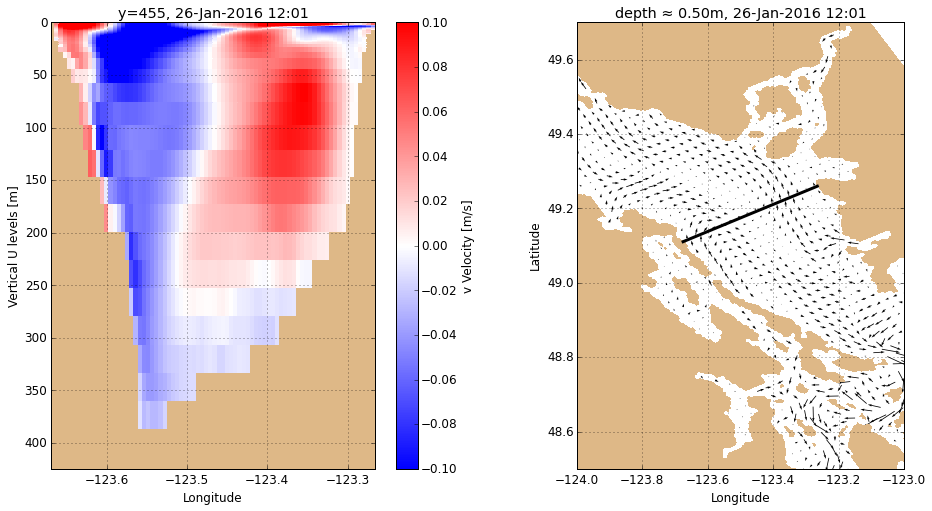

In [236]:
# Load results U.nc and V.nc
surface_currents('2016-jan-26')